In [5]:
import numpy as np
import matplotlib.pyplot as plt
from distance_utils import *
from mrf import rf, rf_weights, rf_par
import skfda
from skfda.misc.operators import SRSF
import matplotlib.pyplot as plt
from ipywidgets import *
from tqdm import tqdm
from skfda._utils import invert_warping
import datahelpers

from fisher_rao_amplitude import d, frechet_mean

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
df = datahelpers.load_data()
grid = np.linspace(0, 1, 100)

y = skfda.FDataGrid(np.stack(df.grid_aligned_depth_norm.to_list()), grid)
x = np.c_[ df.max_depth_std.values, df.duration_std.values, df.bottom_percentage.values ]

# ~8.5k data = 6k train, 2.5k test
test_idx, train_idx = datahelpers.split_idx(df.shape[0], Ntest=2500)

# take 10% of the data, because 8k obs is too much
test_idx = test_idx[:25]
train_idx = train_idx[:60]

x_test = x[test_idx,:]; y_test = y[test_idx]
x_train = x[train_idx,:]; y_train = y[train_idx]

In [10]:
D = D_mat_sq_par(d, y_train, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.2s finished


In [12]:
forest = rf_par(2000, x_train, D, 400, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [13]:
y_preds_data = np.zeros((x_test.shape[0], grid.shape[0]))
errs = np.zeros(x_test.shape[0])
ess = np.zeros(x_test.shape[0])

for i in tqdm(range(x_test.shape[0])):
    ws = rf_weights(forest, x_test[i,:])
    ess[i] = np.sum(ws)**2 / np.sum(np.power(ws,2))
    y_pred = frechet_mean(y_train, ws)
    y_preds_data[i,:] = y_pred.data_matrix[0,...,0]
    
y_preds = y_test.copy(data_matrix=y_preds_data)

for i in tqdm(range(x_test.shape[0])):
    errs[i] = d(y_preds[i], y_test[i])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 67.02it/s]


(array([2., 3., 2., 5., 5., 2., 4., 0., 0., 2.]),
 array([12.24055502, 13.14679828, 14.05304154, 14.95928481, 15.86552807,
        16.77177134, 17.6780146 , 18.58425786, 19.49050113, 20.39674439,
        21.30298766]),
 <BarContainer object of 10 artists>)

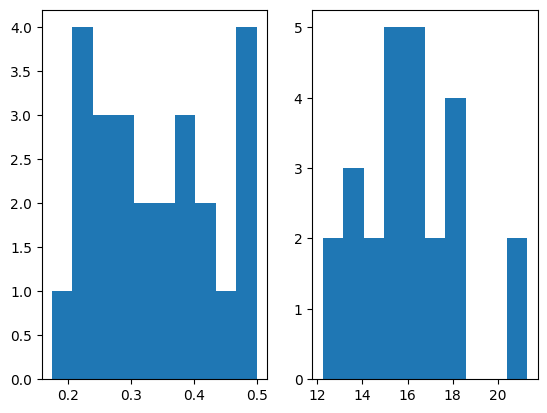

In [14]:
%matplotlib inline
plt.subplot(1,2,1)
plt.hist(errs)
plt.subplot(1,2,2)
plt.hist(ess)

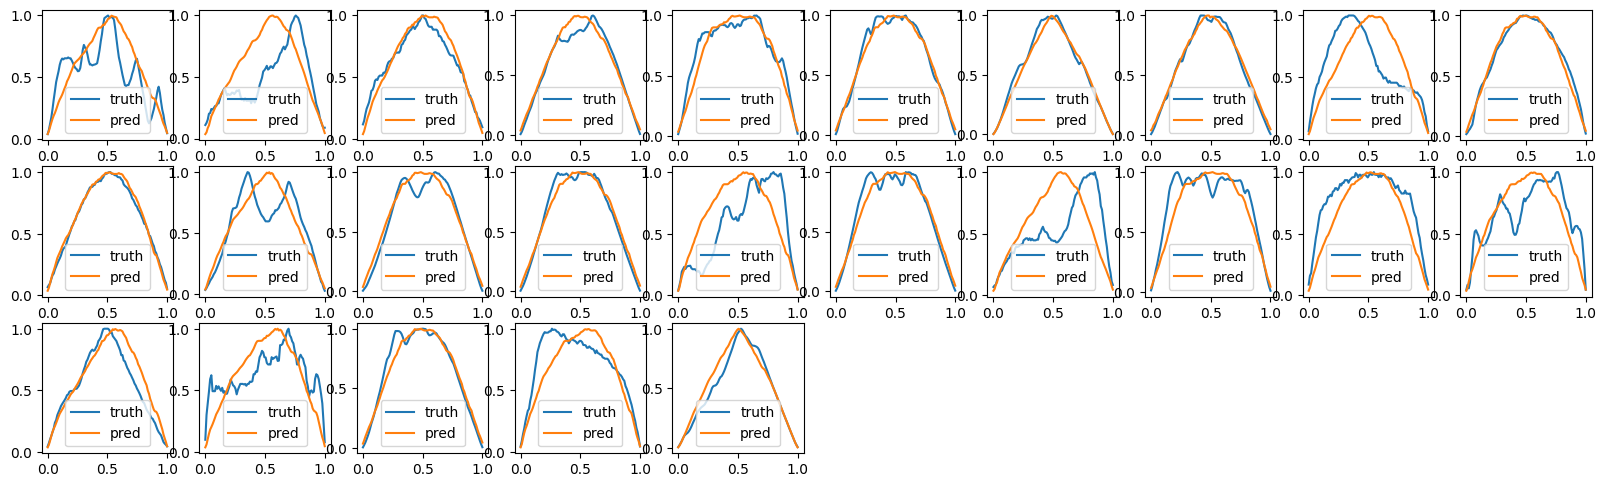

In [17]:
# show the first 100 predictions

plt.figure(figsize=(20, 20))
w = 10
for i in range(min(w*w,x_test.shape[0]):
    plt.subplot(w,w, i+1)
    plt.plot(grid, y_test[i].data_matrix[0,...,0], label='truth')
    plt.plot(grid, y_preds[i].data_matrix[0,...,0], label='pred')
    plt.legend()

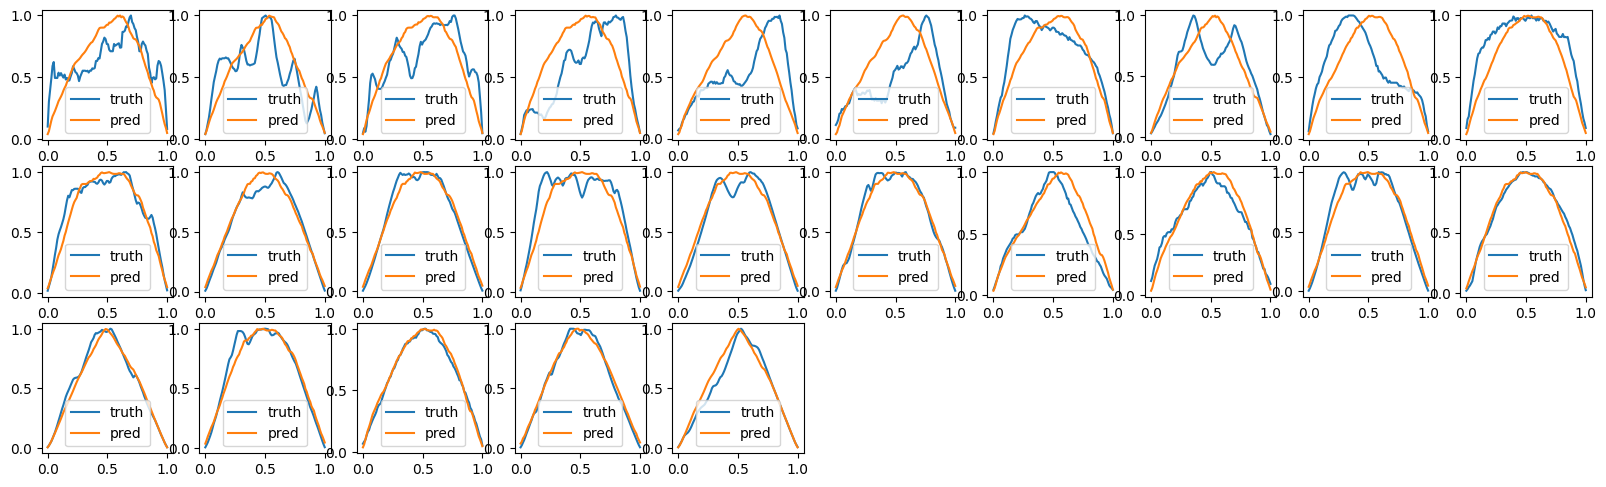

In [20]:
# show the 100 worst predictions

err_perm = np.argsort(-errs)

plt.figure(figsize=(20, 20))
w = 10
for i in range(min(w*w,x_test.shape[0])):
    plt.subplot(w, w, i+1)
    plt.plot(grid, y_test[err_perm[i]].data_matrix[0,...,0], label='truth')
    plt.plot(grid, y_preds[err_perm[i]].data_matrix[0,...,0], label='pred')
    plt.legend()

(array([  77.,  457.,  937., 1647., 2053., 2035.,  982.,  265.,   57.,
           7.]),
 array([0.02735043, 0.1144243 , 0.20149818, 0.28857205, 0.37564593,
        0.4627198 , 0.54979367, 0.63686755, 0.72394142, 0.8110153 ,
        0.89808917]),
 <BarContainer object of 10 artists>)

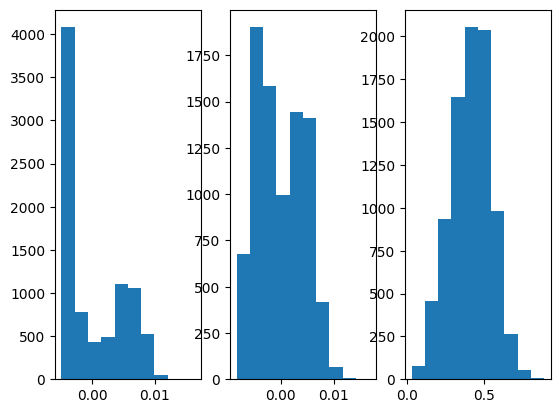

In [58]:
# x = np.c_[ df.max_depth_std.values, df.duration_std.values, df.bottom_percentage.values ]
plt.subplot(1,3,1)
plt.hist(x[:,0])
plt.subplot(1,3,2)
plt.hist(x[:,1])
plt.subplot(1,3,3)
plt.hist(x[:,2])

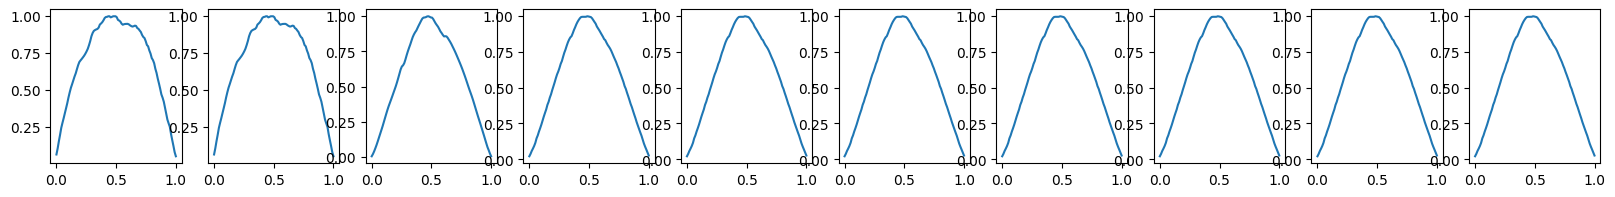

In [85]:
# show how the prediction changes as the max_depth variable increases
# other variables are fixed to their average

ls = np.linspace(x[:,0].min(), x[:,0].max(), 10)
plt.figure(figsize=(20, 2))
for i in range(10):
    ws = rf_weights(forest, [ls[i], x[:,1].mean(), x[:,2].mean()])
    fd_o = fm(y_train, ws)
    plt.subplot(1,10, i+1)
    plt.plot(grid, fd_o.data_matrix[0,...,0])

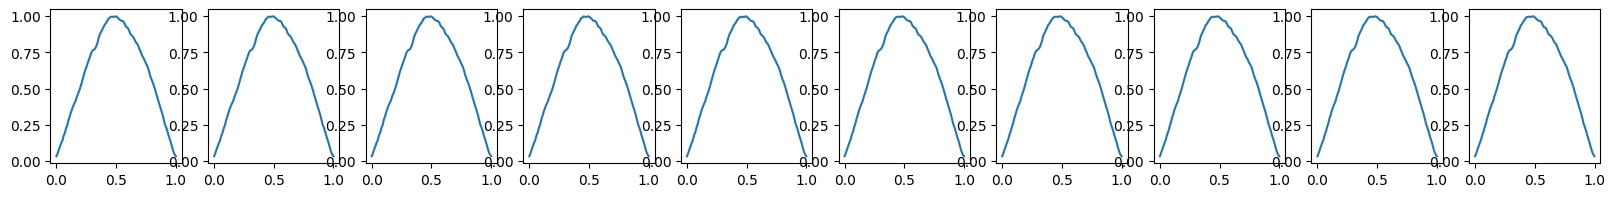

In [86]:
# show how the prediction changes as the duration variable increases
# other variables are fixed to their average

ls = np.linspace(x[:,1].min(), x[:,1].max(), 10)
plt.figure(figsize=(20, 2))
for i in range(10):
    ws = rf_weights(forest, [x[:,0].mean(), ls[i], x[:,2].mean()])
    fd_o = fm(y_train, ws)
    plt.subplot(1,10, i+1)
    plt.plot(grid, fd_o.data_matrix[0,...,0])

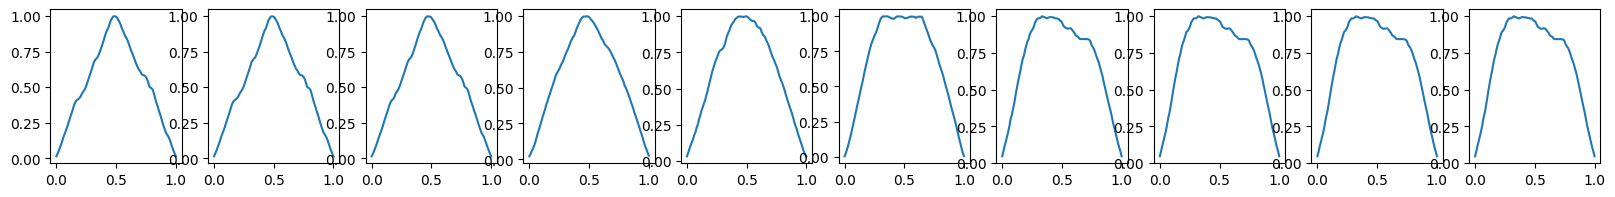

In [84]:
# show how the prediction changes as the bottom_percentage variable increases
# other variables are fixed to their average

ls = np.linspace(x[:,2].min(), x[:,2].max(), 10)
plt.figure(figsize=(20, 2))
for i in range(10):
    ws = rf_weights(forest,  [x[:,0].mean(), x[:,1].mean(), ls[i]])
    fd_o = fm(y_train, ws)
    plt.subplot(1,10, i+1)
    plt.plot(grid, fd_o.data_matrix[0,...,0])